In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# manually add a2e-mmc repos to PYTHONPATH if needed
import os, sys
module_path = os.path.join(os.environ['HOME'],'tools','a2e-mmc')
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from mmctools.plotting import plot_timehistory_at_height, plot_profile, plot_spectrum
from mmctools.helper_functions import calc_wind
import assessment.studies.coupling_comparison.helpers as helper

In [5]:
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.labelsize']  = 16

# SWIFT coupling comparison: Assess virtual tower data
written by [Dries Allaerts](mailto:dries.allaerts@nrel.gov)

Assess data of virtual towers of different microscale simulation. This notebook depends on:
- 10-min data and spectra of microscale simulations generated by `analyse_virtual_tower_data.ipynb`
- reference data:
    - WRF data, generated in `wrf_to_sowfa.ipynb`
    - TTU tower data, generated in `process_TTU_tower.ipynb`
    - TTU radar data, generated in `process_TTU_radar.ipynb`

Names of simulations to assess

In [6]:
sim_datadir = '../postprocessing/data'
simulations = [
    'internal_bcc_wrf_sowfa',
    'internal_pat_wrf_sowfa',
    'internal_pat_obs_sowfa_noT',
]

Reference data

In [7]:
#NetCDF file with WRF data at the SWiFT site generated in wrf_to_sowfa.ipynb, which can be found in
# a2e-mmc/assessment/studies/coupling_comparison/preprocessing/internal/
wrfdata = '../preprocessing/internal/WRF_20131108-09.nc'

# Datasets generated in process_TTU_tower.ipynb, which can be found in
# a2e-mmc/assessment/datasets/SWiFT/
TTU_datadir = '../../../datasets/SWiFT/data'
towerdata_10min = os.path.join(TTU_datadir,'TTU_tilt_corrected_20131108-09_10min.csv')
towerdata       = os.path.join(TTU_datadir,'TTU_tilt_corrected_20131108-09.csv')

# Dataset generated in process_TTU_radar.ipynb, which can be found in
# a2e-mmc/assessment/datasets/SWiFT/
radardata = os.path.join(TTU_datadir,'TTU_obs_QC_20131108.csv')

Heights and times at which spectra are computed

In [8]:
spectra_heights = [10., 32., 80., 120.]
spectra_times = pd.date_range(start='2013-11-08 12:00:00',end='2013-11-09 11:00:00',freq='1h')

## 1. Load data

In [9]:
%%time
df_10min = {}
for sim in simulations:
    print('Reading '+sim)
    # Read data
    df_10min[sim] = pd.read_csv(os.path.join(sim_datadir,sim+'_10min.csv'),
                                             parse_dates=True,
    # Calculate quantities of interest
    helper.calc_QOIs(df_10min[sim])
    
# CPU times: user 372 ms, sys: 25 ms, total: 397 ms
# Wall time: 400 ms

Reading internal_bcc_wrf_sowfa
Reading internal_pat_wrf_sowfa
Reading internal_pat_obs_sowfa_noT
CPU times: user 370 ms, sys: 29.5 ms, total: 400 ms
Wall time: 401 ms


In [10]:
%%time
df_spectra = {}
for sim in simulations:
    print('Reading '+sim)
    df_spectra[sim] = pd.read_csv(os.path.join(sim_datadir,sim+'_spectra.csv'),
                                  parse_dates=True,
                                  index_col=['datetime','height','frequency'])
    
# CPU times: user 1.6 s, sys: 85.7 ms, total: 1.69 s
# Wall time: 1.69 s

Reading internal_bcc_wrf_sowfa
Reading internal_pat_wrf_sowfa
Reading internal_pat_obs_sowfa_noT
CPU times: user 1.62 s, sys: 74.6 ms, total: 1.7 s
Wall time: 1.7 s


## 2. Load reference data

In [11]:
wrf = helper.load_wrf_reference_data(wrfdata)

In [12]:
radar_scan0, radar_scan1 = helper.load_radar_reference_data(radardata)

In [13]:
%%time
tower_10min = helper.load_tower_reference_data(towerdata_10min)
tower_spectra = helper.load_tower_reference_spectra(towerdata,
                                                    spectra_times,spectra_heights,
                                                    interval='1h',window_size='30min')
# CPU times: user 12.6 s, sys: 1.19 s, total: 13.7 s
# Wall time: 13.8 s

CPU times: user 12.8 s, sys: 2.05 s, total: 14.9 s
Wall time: 14.9 s


## 3. Plot virtual tower data

Time history at hub height

In [14]:
zhub = 120

In [15]:
datasets = {}
datasets['WRF mesoscale'] = wrf
datasets['TTU tower'] = tower_10min
for sim in simulations:
    simlabel = sim.replace('internal_','').replace('_sowfa','')
    datasets[simlabel] = df_10min[sim]

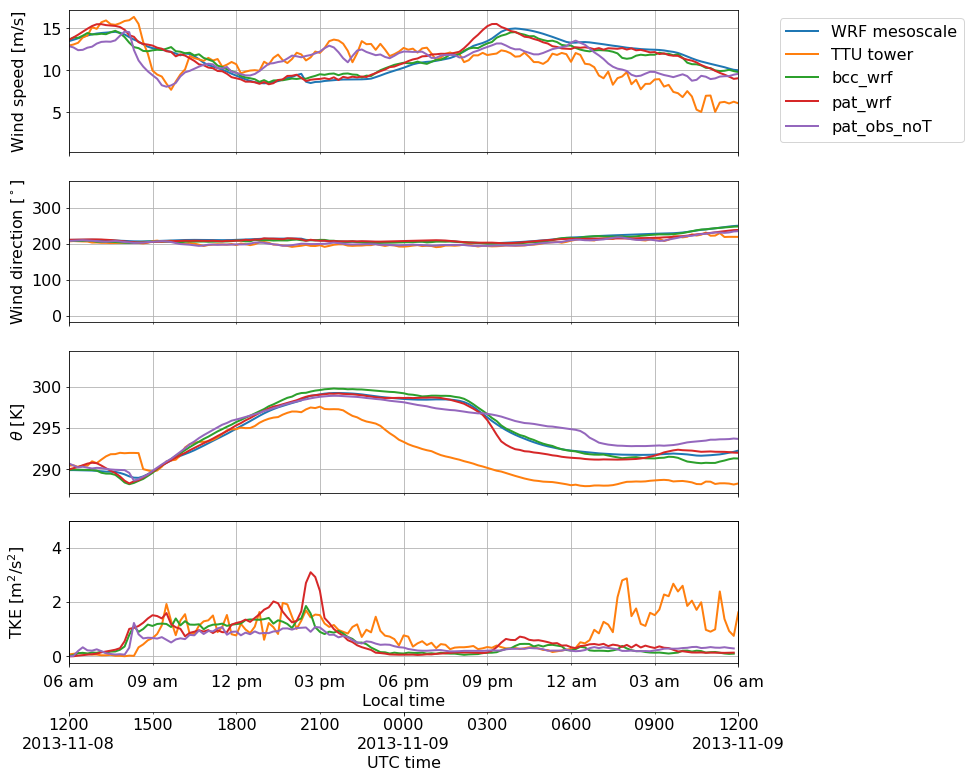

In [16]:
fig,ax,ax2 = plot_timehistory_at_height(
    datasets,
    fields = ['wspd','wdir','theta','TKE'],
    heights = zhub,
    # Specify time limits
    timelimits=('2013-11-08 12:00:00','2013-11-09 12:00:00'),
    # plot local time
    plot_local_time=True,
    local_time_offset=-6,
    #datasetkwargs={'TTU tower':{'linestyle':'','marker':'+','mfc':'none','markersize':6,'color':'k'}},
    # Additional keyword arguments to personalize plotting style
    linewidth=2,linestyle='-',marker=None,
)

#Move xs tick down slightly to avoid overlap with y ticks in ax[1]
ax[-1].tick_params(axis='x', which='minor', pad=10)

# Adjust xaxis tick locations
ax2.xaxis.set_major_locator(mpl.dates.AutoDateLocator(minticks=2,maxticks=3))

Hourly-averaged vertical profiles

In [17]:
df_1h = {}
for sim in simulations:
    df_1h[sim] = df_10min[sim].unstack().resample('1h').mean().stack()

In [18]:
tower_1h = tower_10min.unstack().resample('1h').mean().stack()
radar_scan0_1h = radar_scan0.unstack().resample('1h').mean().stack()
radar_scan1_1h = radar_scan1.unstack().resample('1h').mean().stack()
wrf_1h = wrf.unstack().resample('1h').mean().stack()

In [19]:
datasets = {}
datasets['WRF mesoscale'] = wrf_1h
for sim in simulations:
    simlabel = sim.replace('internal_','').replace('_sowfa','')
    datasets[simlabel] = df_1h[sim]
datasets['TTU tower'] = tower_1h
datasets['TTU radar (scan type 0)'] = radar_scan0_1h
datasets['TTU radar (scan type 1)'] = radar_scan1_1h

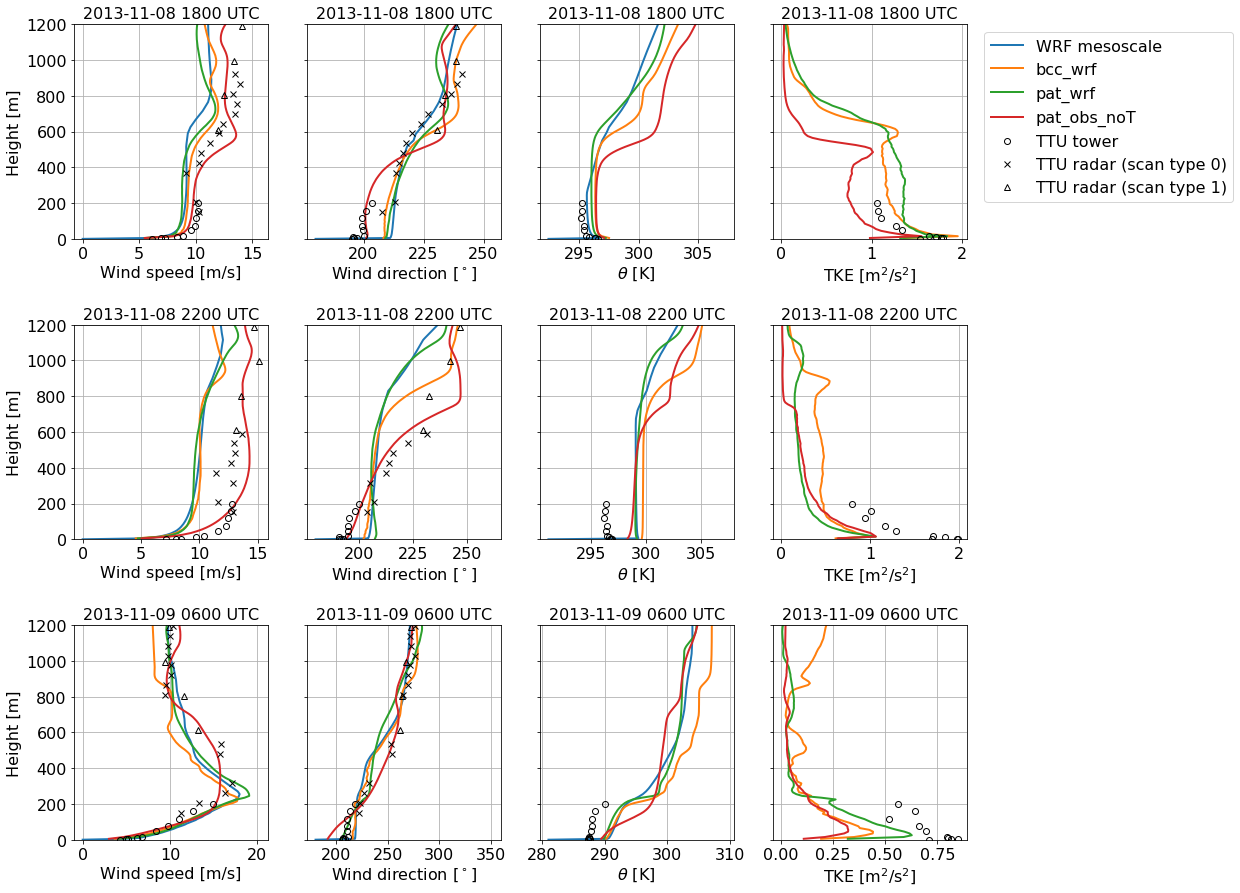

In [20]:
fig,ax = plot_profile(
    datasets,
    fields=['wspd','wdir','theta','TKE'],
    times=['2013-11-08 18:00:00','2013-11-08 22:00:00','2013-11-09 06:00:00'],
    # Specify height limits
    heightlimits=(0,1200),
    # Stack results by dataset instead of times
    stack_by_datasets=True,
    # Change field order to have different fields correspond to different columns instead of rows
    fieldorder='F',
    datasetkwargs={'TTU tower':{'linestyle':'','marker':'o','mfc':'none','markersize':6,'color':'k'},
                   'TTU radar (scan type 0)':{'linestyle':'','marker':'x','mfc':'none','markersize':6,'color':'k'},
                   'TTU radar (scan type 1)':{'linestyle':'','marker':'^','mfc':'none','markersize':6,'color':'k'}
                  },
    # Additional keyword arguments to personalize plotting style
    linewidth=2,
)

Turbulence spectra

In [21]:
datasets = {}
datasets['TTU tower'] = tower_spectra
for sim in simulations:
    simlabel = sim.replace('internal_','').replace('_sowfa','')
    datasets[simlabel] = df_spectra[sim]

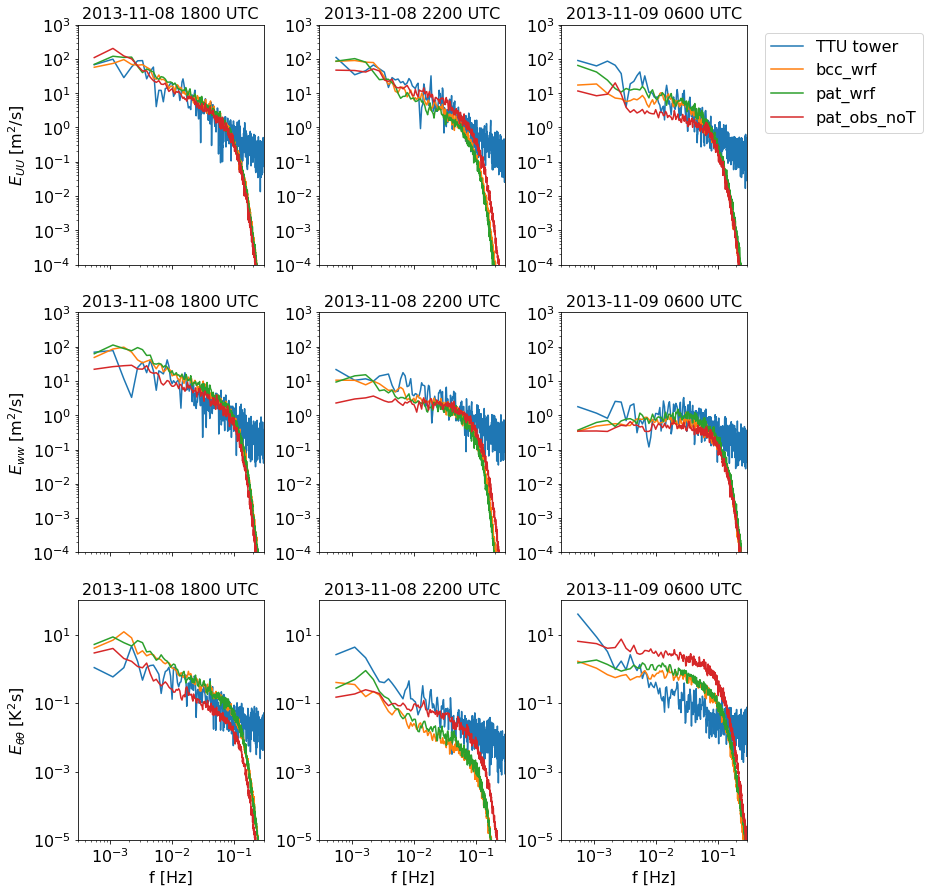

In [22]:
fig,ax = plot_spectrum(
    datasets,
    height=zhub,
    times=['2013-11-08 18:00:00','2013-11-08 22:00:00','2013-11-09 06:00:00'],
    fields=['wspd','w','theta'],
    freqlimits=(0.0003,0.3),
    fieldlimits={'wspd':(1.0e-4,1.0e3),'w':(1.0e-4,1.0e3),'theta':(1.0e-5,1.0e2)},
)

## 4. Performance metrics

In [23]:
# Gather statistics for selected fields
selected_fields = ['wspd','wdir','theta','TKE','TI']

# Gather statistics for several time periods starting at
# selected times covering a certain time interval
selected_times = [
    '2013-11-08 18:00:00',
    '2013-11-08 22:00:00',
    '2013-11-09 06:00:00'
]
interval = '1h'

# Simulations to compute metrics for
selected_sims = ['wrf',] + simulations

# Metrics that will be considered
# Note that the actual calculation of these metrics needs to
# be implemented below in section 4b
metrics = ['MAE','ME','STD']

# Dimensions of reference rotor span
zhub = 120.       # Hub height of interest
diameter = 160.   # Rotor diameter of interest

### 4a. Compute rotor-averaged quantities

Average quantities of interest vertically over a region representative of a reference rotor span with given `diameter` and `zhub`. The averaging is strictly over the vertical direction and the horizontal extent does not vary with height, i.e., the effective area of different horizontal segments corresponding to different vertical locations across the swept rotor area are not taken into account.

In [24]:
df_ravg = {}
df_ravg['tower'] = helper.calc_rotor_average(tower_10min,zhub,diameter)
df_ravg['wrf']   = helper.calc_rotor_average(wrf,zhub,diameter)
for sim in simulations:
    df_ravg[sim] = helper.calc_rotor_average(df_10min[sim],zhub,diameter)

/home/dallaert/.conda-envs/py3env/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:610: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


### 4b. Calculate mean error and standard deviation from average over rotor region

Step 1: Create an empty Dataframe with appropriate number of indices and columns

In [25]:
# Create index
midx = pd.MultiIndex.from_product([pd.to_datetime(selected_times), # Selected times
                                   metrics,                        # Metrics
                                   selected_sims],                 # List of simulations including wrf
                                  names=['datetime','metric','sim'])

# Create field of NaNs to fill dataframe
nanfield = np.nan*np.ones((midx.size,len(selected_fields)))

# Create dataframe
metrics = pd.DataFrame(nanfield,columns=selected_fields,index=midx)
metrics.head()

wspd  wdir  theta  TKE  \
datetime            metric sim                                                  
2013-11-08 18:00:00 MAE    wrf                          NaN   NaN    NaN  NaN   
                           internal_bcc_wrf_sowfa       NaN   NaN    NaN  NaN   
                           internal_pat_wrf_sowfa       NaN   NaN    NaN  NaN   
                           internal_pat_obs_sowfa_noT   NaN   NaN    NaN  NaN   
                    ME     wrf                          NaN   NaN    NaN  NaN   

                                                       TI  
datetime            metric sim                             
2013-11-08 18:00:00 MAE    wrf                        NaN  
                           internal_bcc_wrf_sowfa     NaN  
                           internal_pat_wrf_sowfa     NaN  
                           internal_pat_obs_sowfa_noT NaN  
                    ME     wrf                        NaN

In [26]:
# Loop over different time periods
for time in selected_times:
    # Start and end of the period for which error metrics are calculated
    tstart = pd.to_datetime(time)
    tend   = tstart + pd.to_timedelta(interval)
    
    # Get observed rotor-averaged quantities for current period
    obs = df_ravg['tower']
    obs = obs.loc[(obs.index.get_level_values(0)>=tstart) &\
                   (obs.index.get_level_values(0)<=tend)].copy()
    
    # Loop over different datasets
    for dfname in selected_sims:
            
        # Get simulated rotor-averaged quantities for current period
        df  = df_ravg[dfname]
        df  = df.loc[(df.index.get_level_values(0)>=tstart) &\
                                   (df.index.get_level_values(0)<=tend)].copy()
        
        # Loop over different quantities of interest
        for field in selected_fields:
            try:
                # Compute metrics and store in dataframe
                metrics.loc[(time,'MAE',dfname),field] = np.nanmean(np.abs(df[field].values-obs[field].values))
                metrics.loc[(time,'ME',dfname),field]  = (df[field].values-obs[field].values).mean()
                metrics.loc[(time,'STD',dfname),field] = (df[field].values-obs[field].values).std()
            except KeyError:
                pass

In [27]:
metrics

wspd       wdir  \
datetime            metric sim                                               
2013-11-08 18:00:00 MAE    wrf                         1.405104  11.564555   
                           internal_bcc_wrf_sowfa      1.087263   8.152733   
                           internal_pat_wrf_sowfa      1.517185  10.306996   
                           internal_pat_obs_sowfa_noT  0.511200   2.389694   
                    ME     wrf                        -1.405104  11.564555   
                           internal_bcc_wrf_sowfa     -1.087263   8.152733   
                           internal_pat_wrf_sowfa     -1.517185  10.306996   
                           internal_pat_obs_sowfa_noT -0.511200   0.090556   
                    STD    wrf                         0.583322   2.219731   
                           internal_bcc_wrf_sowfa      0.537462   2.702441   
                           internal_pat_wrf_sowfa      0.479977   2.005562   
                           internal_pat_obs_sowfa_noT  0.319824   2.582384   
2013-11-08 22:00:00 MAE    wrf                         3.533635   8.542564   
                           internal_bcc_wrf_sowfa      3.118729   6.704175   
                           internal_pat_wrf_sowfa      3.227468   9.923834   
                           internal_pat_obs_sowfa_noT  0.884825   2.194685   
                    ME     wrf                        -3.533635   8.542564   
                           internal_bcc_wrf_sowfa     -3.118729   6.704175   
                           internal_pat_wrf_sowfa     -3.227468   9.923834   
                           internal_pat_obs_sowfa_noT -0.668063   1.712386   
                    STD    wrf                         0.773793   1.734427   
                           internal_bcc_wrf_sowfa      0.901394   3.196380   
                           internal_pat_wrf_sowfa      0.774291   1.787355   
                           internal_pat_obs_sowfa_noT  0.699010   1.448898   
2013-11-09 06:00:00 MAE    wrf                         1.957104   6.931316   
                           internal_bcc_wrf_sowfa      1.330475   5.872350   
                           internal_pat_wrf_sowfa      1.493838   2.378464   
                           internal_pat_obs_sowfa_noT  1.016804   1.830031   
                    ME     wrf                         1.957104   6.931316   
                           internal_bcc_wrf_sowfa      1.330475   5.872350   
                           internal_pat_wrf_sowfa      1.493838   2.081261   
                           internal_pat_obs_sowfa_noT  1.016804  -1.767810   
                    STD    wrf                         0.682843   1.996553   
                           internal_bcc_wrf_sowfa      0.711976   2.461240   
                           internal_pat_wrf_sowfa      0.666672   1.743370   
                           internal_pat_obs_sowfa_noT  0.437317   1.443481   

                                                          theta       TKE  \
datetime            metric sim                                              
2013-11-08 18:00:00 MAE    wrf                         0.523531       NaN   
                           internal_bcc_wrf_sowfa      1.161643  0.304528   
                           internal_pat_wrf_sowfa      0.877827  0.362940   
                           internal_pat_obs_sowfa_noT  1.170647  0.285966   
                    ME     wrf                         0.510759       NaN   
                           internal_bcc_wrf_sowfa      1.161643  0.239430   
                           internal_pat_wrf_sowfa      0.877827  0.335173   
                           internal_pat_obs_sowfa_noT  1.170647 -0.198653   
                    STD    wrf                         0.328490       NaN   
                           internal_bcc_wrf_sowfa      0.237536  0.264312   
                           internal_pat_wrf_sowfa      0.310206  0.327713   
                           internal_pat_obs_sowfa_noT  0.134073  0.280695   
2013-11-08 22:00

### 4c. Plot performance metrics

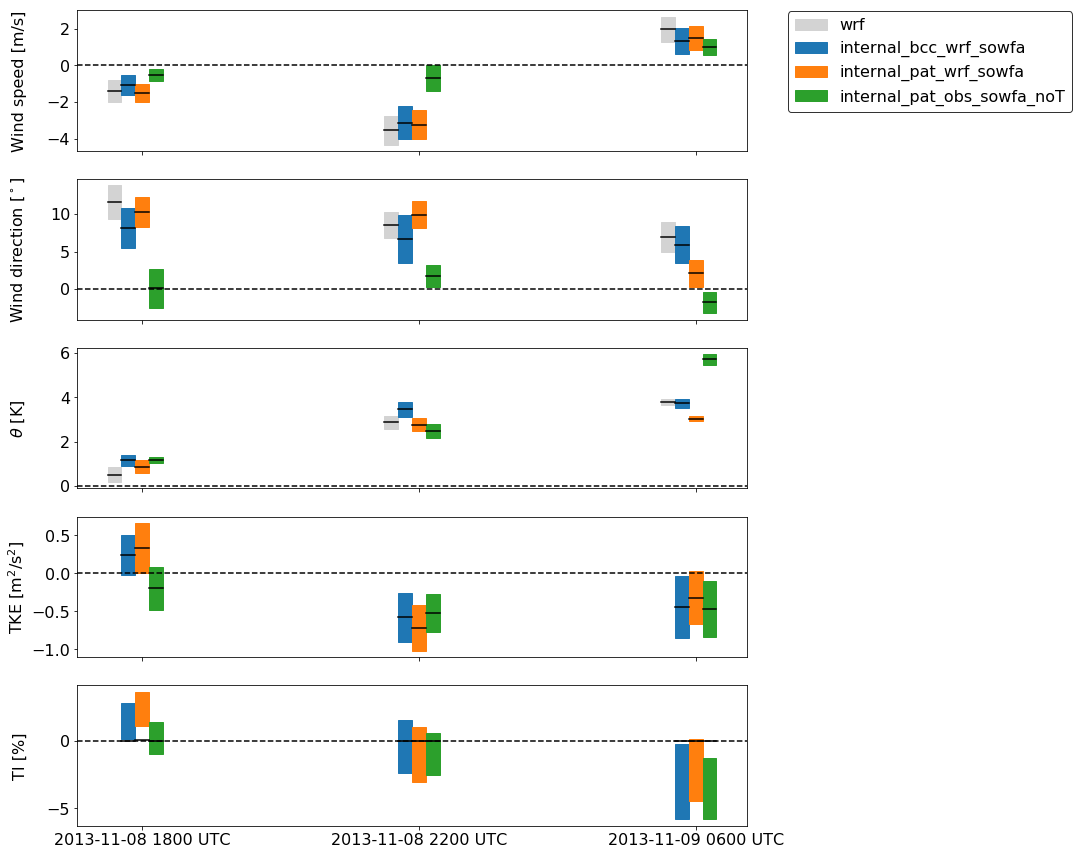

In [28]:
nrows = len(selected_fields)
fig, ax = plt.subplots(nrows,1,sharex=True,figsize=(12,3*nrows))
bar_width = 0.05

# Loop over fields and simulations
for i, field in enumerate(selected_fields):
    for j,dfname in enumerate(selected_sims):
        # Scale TI to be in percentage
        scale = 1
        if field == 'TI':
            scale = 100
        
        # Set color of wrf to gray
        if dfname=='wrf':
            color = 'lightgray'
        else:
            color = plt.rcParams['axes.prop_cycle'].by_key()['color'][j-1]
        
        # Loop over selected times
        for k, time in enumerate(selected_times):
            # Retrieve error metrics
            ME  = metrics.loc[(time,'ME',dfname),field].values
            STD = metrics.loc[(time,'STD',dfname),field].values
                
            # Compute x,y,width,height of bar based on ME and STD
            width = bar_width
            height = 2*STD
            x = k+(j-0.5)*width
            y = ME-STD
            
            # Scale y and height
            y *= scale
            height *= scale
                
            # Set label (only once)
            if k==0:
                label=dfname
            else:
                label=None
                    
            # Create rectangle and add to plot
            rect = mpl.patches.Rectangle((x,y),width,height,label=label,color=color)
            ax[i].add_patch(rect)
            # Plot horizontal line at ME
            ax[i].plot([x,x+width],[ME,ME],'-k',solid_capstyle='projecting')       

# Add zero line
for axi in ax:
    axi.axhline(color='k',linestyle='--')  

# Mark-up legend
leg = ax[0].legend(loc='upper left',bbox_to_anchor=(1.05,1.05),fontsize=16)
leg.get_frame().set_edgecolor('k')

# Mark-up x axis
ax[0].set_xticks(np.arange(len(selected_times)) + 2*bar_width)
ax[0].set_xticklabels(pd.to_datetime(selected_times).strftime('%Y-%m-%d %H%M UTC'),fontsize=16)

# Mark-up y axis
ax[0].set_ylabel('Wind speed [m/s]')
ax[1].set_ylabel(r'Wind direction [$^\circ$]')
ax[2].set_ylabel(r'$\theta$ [K]')
ax[3].set_ylabel(r'TKE [$\mathrm{m^2/s^2}$]')
ax[4].set_ylabel('TI [%]')
fig.align_ylabels()